<a href="https://www.bigdatauniversity.com"><img src="https://ibm.box.com/shared/static/cw2c7r3o20w9zn8gkecaeyjhgw3xdgbj.png" width="400" align="center"></a>

<h1 align="center"><font size="5">Classification with Python</font></h1>

In this notebook we try to practice all the classification algorithms that we learned in this course.

We load a dataset using Pandas library, and apply the following algorithms, and find the best one for this specific dataset by accuracy evaluation methods.

Lets first load required libraries:

In [1]:
# Import Required Libraries
import itertools
import matplotlib.pyplot as plt     # Data Visualization
import matplotlib.ticker as ticker  # Ticker
import numpy             as np      # Array Handling
import pandas            as pd      # Data Handling
from matplotlib.ticker import NullFormatter  # NullFormatter
from sklearn           import preprocessing  # Data Preprocessing/Cleaning
%matplotlib inline

## 1. Data Preprocessing

#### Given Information on Data Structure

This dataset is about past loans. The __Loan_train.csv__ data set includes details of 346 customers whose loan are already paid off or defaulted. It includes following fields:

| Field          | Description                                                                           |
|----------------|---------------------------------------------------------------------------------------|
| Loan_status    | Whether a loan is paid off on in collection                                           |
| Principal      | Basic principal loan amount at the                                                    |
| Terms          | Origination terms which can be weekly (7 days), biweekly, and monthly payoff schedule |
| Effective_date | When the loan got originated and took effects                                         |
| Due_date       | Since it’s one-time payoff schedule, each loan has one single due date                |
| Age            | Age of applicant                                                                      |
| Education      | Education of applicant                                                                |
| Gender         | The gender of applicant                                                               |

#### Download the Dataset

In [2]:
# Download Dataset
!wget -O loan_train.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_train.csv

--2019-04-16 20:09:56--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_train.csv
Resolving s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.193
Connecting to s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)|67.228.254.193|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 23101 (23K) [text/csv]
Saving to: ‘loan_train.csv’

100%[======================================>] 23,101      --.-K/s   in 0.002s  

2019-04-16 20:09:56 (13.5 MB/s) - ‘loan_train.csv’ saved [23101/23101]



#### Load the Dataset and Preview It

In [3]:
# Load Dataset
df = pd.read_csv("loan_train.csv")

In [4]:
# Shape of Data
df.shape

(346, 10)

In [5]:
# Preview of Data
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,9/8/2016,10/7/2016,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,9/8/2016,10/7/2016,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,9/8/2016,9/22/2016,27,college,male
3,4,4,PAIDOFF,1000,30,9/9/2016,10/8/2016,28,college,female
4,6,6,PAIDOFF,1000,30,9/9/2016,10/8/2016,29,college,male


#### Preliminary Data Cleaning

In [6]:
# Standardize Column Names
df.rename(columns={"Unnamed: 0":"unnamed_0",
                   "Unnamed: 0.1":"unnamed_1",
                   "Principal":"principal",
                   "Gender":"gender"}, inplace=True)
df.head()

,unnamed_0,unnamed_1,loan_status,principal,terms,effective_date,due_date,age,education,gender
0,0,0,PAIDOFF,1000,30,9/8/2016,10/7/2016,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,9/8/2016,10/7/2016,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,9/8/2016,9/22/2016,27,college,male
3,4,4,PAIDOFF,1000,30,9/9/2016,10/8/2016,28,college,female
4,6,6,PAIDOFF,1000,30,9/9/2016,10/8/2016,29,college,male


In [7]:
# Convert Dates to Datetime Objects
df["due_date"] = pd.to_datetime(df["due_date"])
df["effective_date"] = pd.to_datetime(df["effective_date"])
df.head()

,unnamed_0,unnamed_1,loan_status,principal,terms,effective_date,due_date,age,education,gender
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male


In [8]:
# Convert "gender" Categorical Feature to be Numeric
df["gender"].replace(to_replace=["male","female"], value=[0,1], inplace=True)
df.head()

,unnamed_0,unnamed_1,loan_status,principal,terms,effective_date,due_date,age,education,gender
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,1
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,0


In [9]:
# Convert "education" Categorical Feature to be Numeric
df = pd.concat([df, pd.get_dummies(df["education"])], axis=1)
df.head()

,unnamed_0,unnamed_1,loan_status,principal,terms,effective_date,due_date,age,education,gender,Bechalor,High School or Below,Master or Above,college
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,0,0,1,0,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,1,1,0,0,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,0,0,0,0,1
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,1,0,0,0,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,0,0,0,0,1


In [10]:
# Standardize (and Spellcheck lol) Column Names
df.rename(columns={"Bechalor":"bachelors",
                   "High School or Below":"high-school or below",
                   "Master or Above":"masters or above"}, inplace=True)
df.head()

,unnamed_0,unnamed_1,loan_status,principal,terms,effective_date,due_date,age,education,gender,bachelors,high-school or below,masters or above,college
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,0,0,1,0,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,1,1,0,0,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,0,0,0,0,1
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,1,0,0,0,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,0,0,0,0,1


In [11]:
# Drop High-School or Below, This is The Same As If All the Rest Are 0
df.drop(["high-school or below"], axis=1, inplace=True)
# Drop Original Categorical Education Column
df.drop(["education"], axis=1, inplace=True)
df.head()

,unnamed_0,unnamed_1,loan_status,principal,terms,effective_date,due_date,age,gender,bachelors,masters or above,college
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,0,0,0,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,1,1,0,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,0,0,0,1
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,1,0,0,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,0,0,0,1


#### Visualization/Investigation of Data

In [12]:
# Install Seaborn for Data Visualization
!conda install -c anaconda seaborn -y
import seaborn as sns

Fetching package metadata .............
Solving package specifications: .

# All requested packages already installed.
# packages in environment at /opt/conda/envs/DSX-Python35:
#
seaborn                   0.9.0                    py35_0    anaconda


In [13]:
# Value Counts of Our Labels
df["loan_status"].value_counts()

PAIDOFF       260
COLLECTION     86
Name: loan_status, dtype: int64

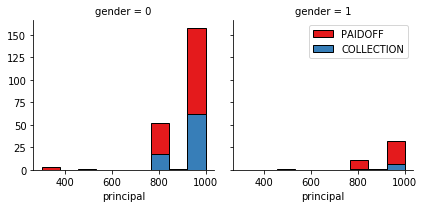

In [14]:
# Graph Number of PAIDOFF and COLLECTION Loans vs. the Principal (For Men vs. Women)
bins = np.linspace(df["principal"].min(), df["principal"].max(), 10)
g = sns.FacetGrid(df, col="gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, "principal", bins=bins, ec="k")
g.axes[-1].legend()
plt.show()

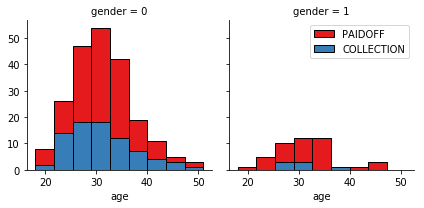

In [15]:
# Graph Number of PAIDOFF and COLLECTION Loans vs. the Age (For Men vs. Women)
bins = np.linspace(df["age"].min(), df["age"].max(), 10)
g = sns.FacetGrid(df, col="gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, "age", bins=bins, ec="k")
g.axes[-1].legend()
plt.show()

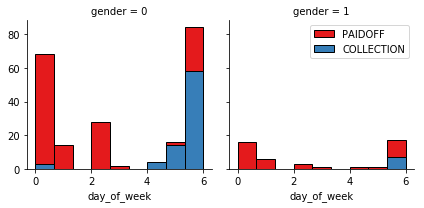

In [16]:
# Data Investigation -> Maybe Day of Week is Significant?

# Add Day of Week Column
df["day_of_week"] = df["effective_date"].dt.dayofweek
# Calculate Bins
bins = np.linspace(df["day_of_week"].min(), df["day_of_week"].max(), 10)
# Create Seaborn Graph with Data
g = sns.FacetGrid(df, col="gender", hue="loan_status", palette="Set1", col_wrap=2)
# Map Graph as Histogram
g.map(plt.hist, "day_of_week", bins=bins, ec="k")
# Add Legend to Last Subplot
g.axes[-1].legend()
# Show Graph
plt.show()

In [17]:
# Looks Like There is Some Significance, Loans on the Weekend Aren't Paidoff

# Add Binary Column Representing Weekend
df["weekend"] = df["day_of_week"].apply(lambda x: 1 if (x>3) else 0)
# Drop Day of Week Column
df.drop(["day_of_week"], axis=1, inplace=True)
df.head()

,unnamed_0,unnamed_1,loan_status,principal,terms,effective_date,due_date,age,gender,bachelors,masters or above,college,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,0,0,0,0,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,1,1,0,0,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,0,0,0,1,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,1,0,0,1,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,0,0,0,1,1


#### Choose Feature/Label Set

In [18]:
# Select our Feature Set
X = df[["principal", "terms", "age", "gender", "weekend", "bachelors", "masters or above", "college"]].values
X[0:5]

array([[1000,   30,   45,    0,    0,    0,    0,    0],
       [1000,   30,   33,    1,    0,    1,    0,    0],
       [1000,   15,   27,    0,    0,    0,    0,    1],
       [1000,   30,   28,    1,    1,    0,    0,    1],
       [1000,   30,   29,    0,    1,    0,    0,    1]])

In [19]:
# Normalize Feature Set Data
X = preprocessing.StandardScaler().fit(X).transform(X)
X[0:5]

/opt/conda/envs/DSX-Python35/lib/python3.5/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


array([[ 0.51578458,  0.92071769,  2.33152555, -0.42056004, -1.20577805,
        -0.38170062, -0.07624929, -0.86968108],
       [ 0.51578458,  0.92071769,  0.34170148,  2.37778177, -1.20577805,
         2.61985426, -0.07624929, -0.86968108],
       [ 0.51578458, -0.95911111, -0.65321055, -0.42056004, -1.20577805,
        -0.38170062, -0.07624929,  1.14984679],
       [ 0.51578458,  0.92071769, -0.48739188,  2.37778177,  0.82934003,
        -0.38170062, -0.07624929,  1.14984679],
       [ 0.51578458,  0.92071769, -0.3215732 , -0.42056004,  0.82934003,
        -0.38170062, -0.07624929,  1.14984679]])

In [20]:
# Select our Label Set
y = df["loan_status"].values
y[0:5]

array(['PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF'], dtype=object)

## 2. Classification

Now, it is your turn, use the training set to build an accurate model. Then use the test set to report the accuracy of the model.<br>
You should use the following algorithms:
- K Nearest Neighbor(KNN)
- Decision Tree
- Support Vector Machine
- Logistic Regression



__ Notice:__ 
- (Done)    You can go above and change the pre-processing, feature selection, feature-extraction, and so on, to make a better model.
- (sklearn) You should use either scikit-learn, Scipy or Numpy libraries for developing the classification algorithms.
- (Done)    You should include the code of the algorithm in the following cells.

#### K Nearest Neighbor(KNN)
Notice: You should find the best k to build the model with the best accuracy.  
**warning:** You should not use the __loan_test.csv__ for finding the best k, however, you can split your train_loan.csv into train and test to find the best __k__.

In [21]:
# Import Packages
from sklearn import metrics
from sklearn.model_selection import train_test_split     as tts
from sklearn.neighbors       import KNeighborsClassifier as kNN

In [22]:
# Split Data into Train Set and Test Set
X_train, X_test, y_train, y_test = tts(X, y, test_size=0.2, random_state=4)
print("Training Set -> X Shape: "+str(X_train.shape)+" | y Shape: "+str(y_train.shape))
print("Test Set     -> X Shape: "+str(X_test.shape)+" | y Shape: "+str(y_test.shape))

Training Set -> X Shape: (276, 8) | y Shape: (276,)
Test Set     -> X Shape: (70, 8) | y Shape: (70,)


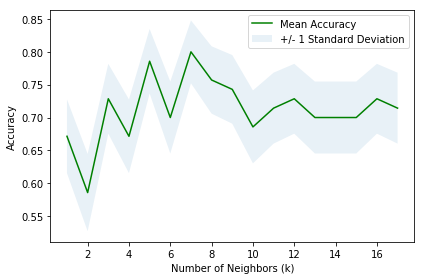

The best accuracy was 0.8 and achieved with a k=7.


In [23]:
# Selecting K (n_neighbors)
#   Doing some research led me to find that k = sqrt(n) is a good guess
#   for the optimal value of k. In order to really test this, I will make
#   this the maximum k and try all the k's in steps of one until that number
#   is reached. The k with the best resulting accuracy will be selected.
#   Research also recommended selecting an odd value of k to avoid confusion.
def find_max_k(n):
    max_k = np.trunc(np.sqrt(n))+1
    if max_k%2 == 0:
        return max_k+1
    else:
        return max_k    
max_k = find_max_k(X_train.shape[0]).astype(int)

# Loop Through k's, Create Model and Store Accuracies and Standard Deviations
accuracy_mean = np.zeros((max_k))
accuracy_std  = np.zeros((max_k))
for k in range(1, max_k+1):
    kNN_model = kNN(n_neighbors=k).fit(X_train,y_train)
    kNN_preds = kNN_model.predict(X_test)
    accuracy_mean[k-1] = metrics.accuracy_score(y_test, kNN_preds)
    accuracy_std[k-1]  = np.std(y_test==kNN_preds)/np.sqrt(kNN_preds.shape[0])
    
# Plot Results of Iterations
plt.plot(range(1, max_k+1), accuracy_mean, "g")
plt.fill_between(range(1, max_k+1), accuracy_mean - 1*accuracy_std, accuracy_mean + 1*accuracy_std, alpha=0.10)
plt.legend(("Mean Accuracy","+/- 1 Standard Deviation"))
plt.xlabel("Number of Neighbors (k)")
plt.ylabel("Accuracy")
plt.tight_layout()
plt.show()

# Print Best Results
print("The best accuracy was "+str(accuracy_mean.max())+" and achieved with a k="+str(accuracy_mean.argmax()+1)+".")

#### Decision Tree Classifier

In [24]:
# Import Packages
from sklearn import metrics
from sklearn.model_selection import train_test_split       as tts
from sklearn.tree            import DecisionTreeClassifier as dtc

In [25]:
# Split Data into Train Set and Test Set
X_train, X_test, y_train, y_test = tts(X, y, test_size=0.2, random_state=4)
print("Training Set -> X Shape: "+str(X_train.shape)+" | y Shape: "+str(y_train.shape))
print("Test Set     -> X Shape: "+str(X_test.shape)+" | y Shape: "+str(y_test.shape))

Training Set -> X Shape: (276, 8) | y Shape: (276,)
Test Set     -> X Shape: (70, 8) | y Shape: (70,)


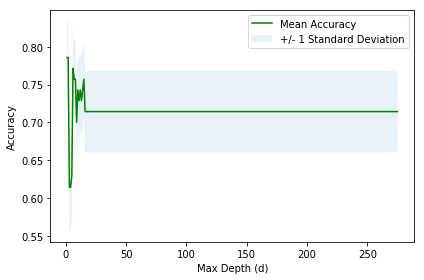

The best accuracy was 0.785714285714 and achieved with a max_depth=1.


In [26]:
# Selecting Max Depth (max_depth)
#   The max possible max depth values is one less than the total number of examples,
#   this would mean that there is a branch for every example.
max_d = X_train.shape[0]-1

# Loop Through d's, Create Model and Store Accuracies and Standard Deviations
accuracy_mean = np.zeros((max_d))
accuracy_std  = np.zeros((max_d))
for d in range(1, max_d+1):
    dtc_model = dtc(criterion="entropy", max_depth=d).fit(X_train,y_train)
    dtc_preds = dtc_model.predict(X_test)
    accuracy_mean[d-1] = metrics.accuracy_score(y_test, dtc_preds)
    accuracy_std[d-1]  = np.std(y_test==dtc_preds)/np.sqrt(dtc_preds.shape[0])
    
# Plot Results of Iterations
plt.plot(range(1, max_d+1), accuracy_mean, "g")
plt.fill_between(range(1, max_d+1), accuracy_mean - 1*accuracy_std, accuracy_mean + 1*accuracy_std, alpha=0.10)
plt.legend(("Mean Accuracy","+/- 1 Standard Deviation"))
plt.xlabel("Max Depth (d)")
plt.ylabel("Accuracy")
plt.tight_layout()
plt.show()

# Print Best Results
print("The best accuracy was "+str(accuracy_mean.max())+" and achieved with a max_depth="+str(accuracy_mean.argmax()+1)+".")

#### Support Vector Machine

In [27]:
# Import Packages
from sklearn import metrics
from sklearn import svm
from sklearn.model_selection import train_test_split       as tts

In [28]:
# Split Data into Train Set and Test Set
X_train, X_test, y_train, y_test = tts(X, y, test_size=0.2, random_state=4)
print("Training Set -> X Shape: "+str(X_train.shape)+" | y Shape: "+str(y_train.shape))
print("Test Set     -> X Shape: "+str(X_test.shape)+" | y Shape: "+str(y_test.shape))

Training Set -> X Shape: (276, 8) | y Shape: (276,)
Test Set     -> X Shape: (70, 8) | y Shape: (70,)


In [29]:
# Selecting Kernel (kernel)
#   There are a few kernel options, I will try them all and choose the one
#   with the best accuracy score.
kernels = ["linear", "poly", "rbf", "sigmoid"]

# Loop Through kernels, Create Model and Store Accuracies and Standard Deviations
accuracy_mean = np.zeros((len(kernels)))
accuracy_std  = np.zeros((len(kernels)))
print("Accuracies for Each Kernel ->")
for index,value in enumerate(kernels):
    svm_model = svm.SVC(kernel=value).fit(X_train,y_train)
    svm_preds = svm_model.predict(X_test)
    accuracy_mean[index] = metrics.accuracy_score(y_test, svm_preds)
    accuracy_std[index] = np.std(y_test==svm_preds)/np.sqrt(svm_preds.shape[0])
    print("Kernel Type: "+str(value)+" | Mean Accuracy: "+str(accuracy_mean[index])+" | Std Accuracy: "+str(accuracy_std[index]))
print("")

# Print Best Results
print("The best accuracy was "+str(accuracy_mean.max())+" and achieved with a kernel type of: "+str(kernels[accuracy_mean.argmax()])+".")

Accuracies for Each Kernel ->
Kernel Type: linear | Mean Accuracy: 0.785714285714 | Std Accuracy: 0.0490433258804
Kernel Type: poly | Mean Accuracy: 0.771428571429 | Std Accuracy: 0.0501891466088
Kernel Type: rbf | Mean Accuracy: 0.728571428571 | Std Accuracy: 0.0531514147159
Kernel Type: sigmoid | Mean Accuracy: 0.728571428571 | Std Accuracy: 0.0531514147159

The best accuracy was 0.785714285714 and achieved with a kernel type of: linear.


#### Logistic Regression

In [30]:
# Import Packages
from sklearn import metrics
from sklearn.metrics         import confusion_matrix
from sklearn.model_selection import train_test_split       as tts
from sklearn.linear_model    import LogisticRegression     as LR

In [31]:
# Split Data into Train Set and Test Set
X_train, X_test, y_train, y_test = tts(X, y, test_size=0.2, random_state=4)
print("Training Set -> X Shape: "+str(X_train.shape)+" | y Shape: "+str(y_train.shape))
print("Test Set     -> X Shape: "+str(X_test.shape)+" | y Shape: "+str(y_test.shape))

Training Set -> X Shape: (276, 8) | y Shape: (276,)
Test Set     -> X Shape: (70, 8) | y Shape: (70,)


In [32]:
# Selecting Solver (solver) and Regularization Strength (C)
solvers = ["newton-cg", "lbfgs", "liblinear", "sag", "saga"]
possible_Cs = [0.001, 0.01, 0.1, 1, 10, 100, 1000]

# Loop Through solvers and c's, Create Model and Store Accuracies and Standard Deviations
accuracy_mean = np.zeros((len(solvers),len(possible_Cs)))
accuracy_std  = np.zeros((len(solvers),len(possible_Cs)))
print("Accuracies for Each Solver/C Pair ->")
print("")
for index1,value1 in enumerate(solvers):
    print("Accuracies for Each C of the Solver: "+str(value1))
    for index2,value2 in enumerate(possible_Cs):
        lr_model = LR(C=value2,solver=value1).fit(X_train,y_train)
        lr_preds = lr_model.predict(X_test)
        accuracy_mean[index1][index2] = metrics.accuracy_score(y_test, lr_preds)
        accuracy_std[index1][index2] = np.std(y_test==lr_preds)/np.sqrt(lr_preds.shape[0])
        print("C: "+str(value2)+" | Mean Accuracy: "+str(accuracy_mean[index1][index2])+" | Std Accuracy: "+str(accuracy_std[index1][index2]))
    print("")
print("")

# Print Best Results
max_acc_val = accuracy_mean.max()
max_acc_idx = np.unravel_index(np.argmax(accuracy_mean, axis=None), accuracy_mean.shape)
max_acc_solver = solvers[max_acc_idx[0]]
max_acc_C = possible_Cs[max_acc_idx[1]]
print("The best accuracy was "+str(max_acc_val)+".")
print("Solver: ", max_acc_solver)
print("     C: ", max_acc_C)


Accuracies for Each Solver/C Pair ->

Accuracies for Each C of the Solver: newton-cg
C: 0.001 | Mean Accuracy: 0.785714285714 | Std Accuracy: 0.0490433258804
C: 0.01 | Mean Accuracy: 0.785714285714 | Std Accuracy: 0.0490433258804
C: 0.1 | Mean Accuracy: 0.757142857143 | Std Accuracy: 0.0512525331807
C: 1 | Mean Accuracy: 0.728571428571 | Std Accuracy: 0.0531514147159
C: 10 | Mean Accuracy: 0.728571428571 | Std Accuracy: 0.0531514147159
C: 100 | Mean Accuracy: 0.714285714286 | Std Accuracy: 0.0539949247156
C: 1000 | Mean Accuracy: 0.714285714286 | Std Accuracy: 0.0539949247156

Accuracies for Each C of the Solver: lbfgs
C: 0.001 | Mean Accuracy: 0.785714285714 | Std Accuracy: 0.0490433258804
C: 0.01 | Mean Accuracy: 0.785714285714 | Std Accuracy: 0.0490433258804
C: 0.1 | Mean Accuracy: 0.757142857143 | Std Accuracy: 0.0512525331807
C: 1 | Mean Accuracy: 0.728571428571 | Std Accuracy: 0.0531514147159
C: 10 | Mean Accuracy: 0.728571428571 | Std Accuracy: 0.0531514147159
C: 100 | Mean Accu

/opt/conda/envs/DSX-Python35/lib/python3.5/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


## 3. Model Evaluation (Using New Test Set)

In [33]:
# Import Packages
from sklearn.metrics import jaccard_similarity_score as jss
from sklearn.metrics import f1_score as f1
from sklearn.metrics import log_loss as ll

First, download and load the test set:

In [34]:
# Download Dataset
!wget -O loan_test.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv

--2019-04-16 20:10:45--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv
Resolving s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.193
Connecting to s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)|67.228.254.193|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3642 (3.6K) [text/csv]
Saving to: ‘loan_test.csv’

100%[======================================>] 3,642       --.-K/s   in 0s      

2019-04-16 20:10:46 (683 MB/s) - ‘loan_test.csv’ saved [3642/3642]



#### Proprocess Test Dataset 

In [35]:
# Load and Show Head
test_df = pd.read_csv('loan_test.csv')
test_df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,1,1,PAIDOFF,1000,30,9/8/2016,10/7/2016,50,Bechalor,female
1,5,5,PAIDOFF,300,7,9/9/2016,9/15/2016,35,Master or Above,male
2,21,21,PAIDOFF,1000,30,9/10/2016,10/9/2016,43,High School or Below,female
3,24,24,PAIDOFF,1000,30,9/10/2016,10/9/2016,26,college,male
4,35,35,PAIDOFF,800,15,9/11/2016,9/25/2016,29,Bechalor,male


In [36]:
# Preprocess (Exact Same as Beginning of Notebook)
test_df.rename(columns={"Unnamed: 0":"unnamed_0",
                   "Unnamed: 0.1":"unnamed_1",
                   "Principal":"principal",
                   "Gender":"gender"}, inplace=True)
test_df["due_date"] = pd.to_datetime(test_df["due_date"])
test_df["effective_date"] = pd.to_datetime(test_df["effective_date"])
test_df["gender"].replace(to_replace=["male","female"], value=[0,1], inplace=True)
test_df = pd.concat([test_df, pd.get_dummies(test_df["education"])], axis=1)
test_df.rename(columns={"Bechalor":"bachelors",
                   "High School or Below":"high-school or below",
                   "Master or Above":"masters or above"}, inplace=True)
test_df.drop(["high-school or below"], axis=1, inplace=True)
test_df.drop(["education"], axis=1, inplace=True)
test_df["day_of_week"] = test_df["effective_date"].dt.dayofweek
test_df["weekend"] = test_df["day_of_week"].apply(lambda x: 1 if (x>3) else 0)
test_df.drop(["day_of_week"], axis=1, inplace=True)

In [37]:
# Feature/Label Selection
test_X = test_df[["principal", "terms", "age", "gender", "weekend", "bachelors", "masters or above", "college"]].values
test_X = preprocessing.StandardScaler().fit(test_X).transform(test_X)
test_y = test_df["loan_status"].values

/opt/conda/envs/DSX-Python35/lib/python3.5/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


#### k-Nearest Neighbors Model Test

In [38]:
# Create Best kNN Model
kNN_model = kNN(n_neighbors=7).fit(X_train,y_train)

# Predict on New Test Set
kNN_preds = kNN_model.predict(test_X)

# Calculate Scores
jaccard_score = jss(test_y, kNN_preds)
f1_score = f1(test_y, kNN_preds, average="weighted")
print("Jaccard Similarity Score: ", jaccard_score)
print("F1 Score: ", f1_score)

Jaccard Similarity Score:  0.685185185185
F1 Score:  0.660225442834


#### Decision Tree Classifier Model Test

In [39]:
# Create Best dtc Model
dtc_model = dtc(criterion="entropy", max_depth=1).fit(X_train,y_train)

# Predict on New Test Set
dtc_preds = dtc_model.predict(test_X)

# Calculate Scores
jaccard_score = jss(test_y, dtc_preds)
f1_score = f1(test_y, dtc_preds, average="weighted")
print("Jaccard Similarity Score: ", jaccard_score)
print("F1 Score: ", f1_score)

Jaccard Similarity Score:  0.740740740741
F1 Score:  0.630417651694


/opt/conda/envs/DSX-Python35/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


#### Support Vector Machine Model Test

In [40]:
# Create Best svm Model
svm_model = svm.SVC(kernel="linear").fit(X_train,y_train)

# Predict on New Test Set
svm_preds = svm_model.predict(test_X)

# Calculate Scores
jaccard_score = jss(test_y, svm_preds)
f1_score = f1(test_y, svm_preds, average="weighted")
print("Jaccard Similarity Score: ", jaccard_score)
print("F1 Score: ", f1_score)

Jaccard Similarity Score:  0.740740740741
F1 Score:  0.630417651694


/opt/conda/envs/DSX-Python35/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


#### Logistic Regression Model Test

In [41]:
# Create Best lr Model
lr_model = LR(C=0.001,solver="newton-cg").fit(X_train,y_train)

# Predict on New Test Set
lr_preds = lr_model.predict(test_X)
lr_preds_probs = lr_model.predict_proba(test_X)

# Calculate Scores
jaccard_score = jss(test_y, lr_preds)
f1_score = f1(test_y, lr_preds, average="weighted")
log_loss = ll(test_y, lr_preds_probs)
print("Jaccard Similarity Score: ", jaccard_score)
print("F1 Score: ", f1_score)
print("Log Loss Score: ", log_loss)

Jaccard Similarity Score:  0.740740740741
F1 Score:  0.630417651694
Log Loss Score:  0.562722586388


/opt/conda/envs/DSX-Python35/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


# Report
You should be able to report the accuracy of the built model using different evaluation metrics:

| Algorithm          | Jaccard | F1-score | LogLoss |
|--------------------|---------|----------|---------|
| KNN                | 0.68519 | 0.660225 | NA      |
| Decision Tree      | 0.74074 | 0.630418 | NA      |
| SVM                | 0.74074 | 0.630418 | NA      |
| LogisticRegression | 0.74074 | 0.630418 | 0.56272 |

After training my best models and testing them with the test set, I found interesting results. It seems that the Decision Tree Classifier, the Support Vector Machine Classifier, and the Logistic Regression Classifier all performed with striking similarity, reaching essentially the exact same Jaccard and F1 Score. The k-Nearest Neighbors Classifier has a lower Jaccard score, but higher F1 score than the three of them. From these results, I'd include that picking one of the three similar models (Decision Tree, Support Vector Machine, Logistic Regression) would yield the best results. Personally, I would choose the Decision Tree Classifier because, in addition to its accurate results, it also provides an easy way of understanding the data and the model through the use of a dendrogram.

Thanks for reviewing my project!
-Royden Lynch

<h2>Want to learn more?</h2>

IBM SPSS Modeler is a comprehensive analytics platform that has many machine learning algorithms. It has been designed to bring predictive intelligence to decisions made by individuals, by groups, by systems – by your enterprise as a whole. A free trial is available through this course, available here: <a href="http://cocl.us/ML0101EN-SPSSModeler">SPSS Modeler</a>

Also, you can use Watson Studio to run these notebooks faster with bigger datasets. Watson Studio is IBM's leading cloud solution for data scientists, built by data scientists. With Jupyter notebooks, RStudio, Apache Spark and popular libraries pre-packaged in the cloud, Watson Studio enables data scientists to collaborate on their projects without having to install anything. Join the fast-growing community of Watson Studio users today with a free account at <a href="https://cocl.us/ML0101EN_DSX">Watson Studio</a>

<h3>Thanks for completing this lesson!</h3>

<h4>Author:  <a href="https://ca.linkedin.com/in/saeedaghabozorgi">Saeed Aghabozorgi</a></h4>
<p><a href="https://ca.linkedin.com/in/saeedaghabozorgi">Saeed Aghabozorgi</a>, PhD is a Data Scientist in IBM with a track record of developing enterprise level applications that substantially increases clients’ ability to turn data into actionable knowledge. He is a researcher in data mining field and expert in developing advanced analytic methods like machine learning and statistical modelling on large datasets.</p>

<hr>

<p>Copyright &copy; 2018 <a href="https://cocl.us/DX0108EN_CC">Cognitive Class</a>. This notebook and its source code are released under the terms of the <a href="https://bigdatauniversity.com/mit-license/">MIT License</a>.</p>